In [4]:
# importing modules
import dvc.api
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import mlflow
from IPython.display import Markdown, display, Image
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('..')))

In [5]:
# importing scripts
import sys
sys.path.insert(0,'../scripts/')
from data_preProcessing import dataProcessor
from data_exploration import dataExplorer
from ltsm_helper import ltsm_time

In [6]:
#Importing the collected Data
path = 'data/cl_trainStore.csv'
repo = '../'
rev = 'V3'
data_url = dvc.api.read(path=path, repo=repo, rev=rev)
scaled = pd.read_csv(data_url)

In [6]:
scaled = pd.read_csv('../data/cl_trainStore.csv')

In [7]:
scaled.head()

,DayOfWeek,WeekDay,Year,Month,Season,Day,Sales,Customers,Open,Promo,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesPerCustomer,CompetitionOpenSince
0,0.501484,0.630672,1.502077,0.346724,0.389712,1.740766,-0.063134,-0.067027,0.452399,1.273237,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.093996,0.595717
1,0.000831,0.630672,1.502077,0.346724,0.389712,1.626969,-0.136239,-0.092863,0.452399,1.273237,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.207208,0.595717
2,-0.499823,0.630672,1.502077,0.346724,0.389712,1.513173,-0.207840,-0.158887,0.452399,1.273237,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.227101,0.595717
3,-1.000476,0.630672,1.502077,0.346724,0.389712,1.399377,-0.138946,-0.052674,0.452399,1.273237,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.303632,0.595717
4,-1.501129,0.630672,1.502077,0.346724,0.389712,1.285581,0.189274,0.096598,0.452399,1.273237,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,0.097227,0.595717


In [8]:
train = pd.read_csv('../data/train.csv')
train = train[['Date','Sales']]
train = train.groupby('Date').agg({'Sales':'mean'})

In [9]:
train.head()

,Sales
Date,
2013-01-01,87.284560
2013-01-02,6233.030493
2013-01-03,5693.112108
2013-01-04,5954.218834
2013-01-05,5337.751570


In [11]:
manu = dataProcessor(train)

In [12]:
# Using StandardScaler to standardize the all columns
scale_list = train.columns.to_list()
manu.standardize_columns(scale_list)

,Sales
Date,
2013-01-01,-1.972829
2013-01-02,0.155989
2013-01-03,-0.031033
2013-01-04,0.059412
2013-01-05,-0.154126
...,...
2015-07-27,1.323292
2015-07-28,0.828649
2015-07-29,0.637557


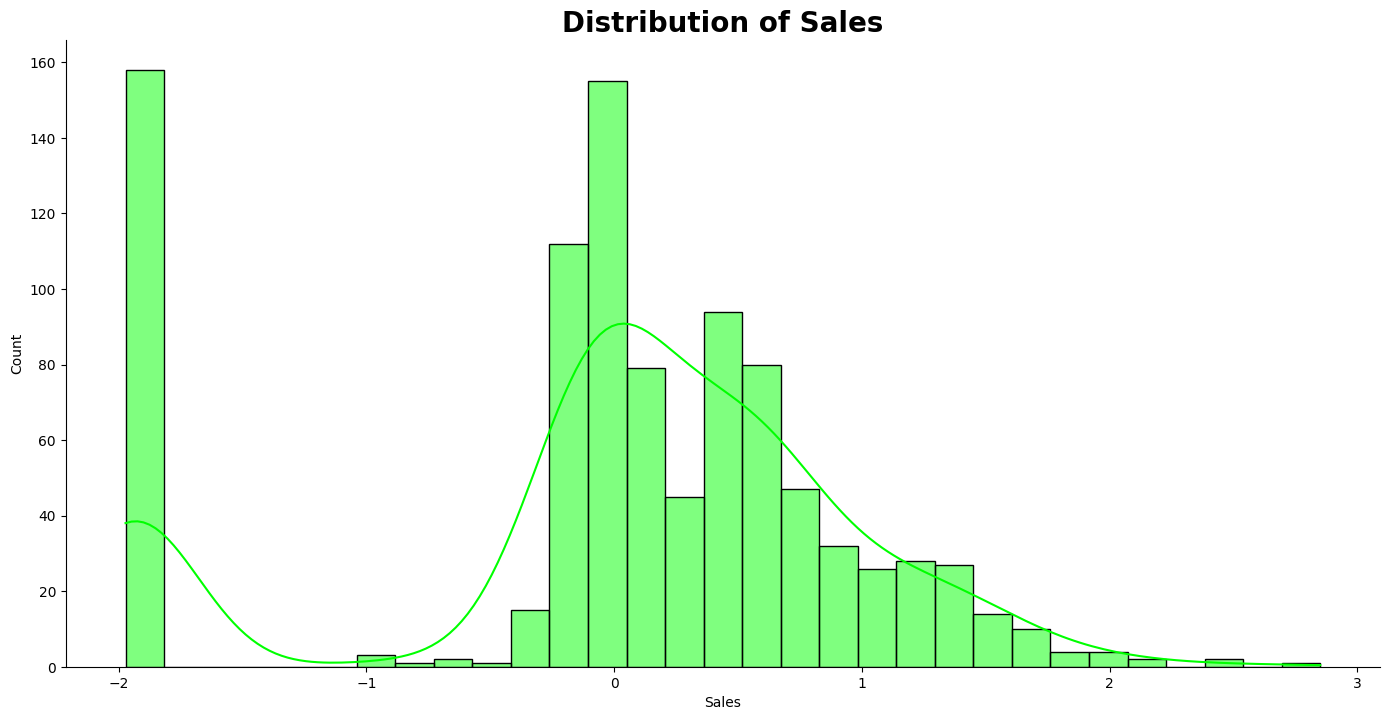

In [14]:
dataExplorer.plot_hist(train, 'Sales', 'lime') 

In [15]:
train["Sales"] = train["Sales"].astype("float")

In [16]:
train["Sales"].isna().any().sum()

0

In [17]:
SIZE = len(train["Sales"])
WINDOW_SIZE = 49
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

t = ltsm_time(WINDOW_SIZE, BATCH_SIZE, train)

2022/09/10 16:20:15 INFO mlflow.tracking.fluent: Experiment with name 'Rossman-Lstm_model' does not exist. Creating a new experiment.
2022/09/10 16:20:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1240      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1/1 [==============================] - 27s 27s/step - loss: 0.4183 - val_loss: 0.3990
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 0.4169 - val_loss: 0.3971
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 0.4155 - val_loss: 0.3954
Epoch 4/200
1/1 [===========

INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp8inh8reu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp8inh8reu\model\data\model\assets


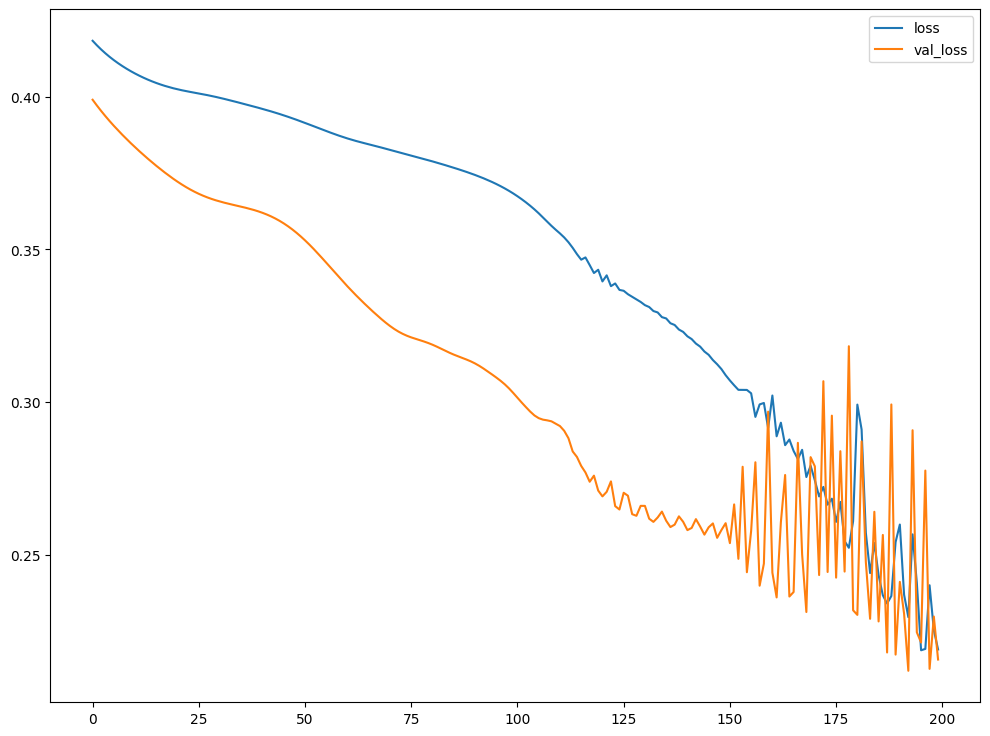

In [18]:
model1, his = t.train(EPOCHS)

In [19]:
# Set window of past points for LSTM model
window = 45

# # Split 80/20 into train/test data
last = int(len(train.Sales)/5.0)
Xtrain = train.Sales[:-last]
Xtest = train.Sales[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

In [20]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [21]:
# Fit LSTM model
history = m.fit(xin, next_X, epochs=700, batch_size=50, verbose=0)

2022/09/10 16:26:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd930e6d280aa4c2083af6e760f5b4b2c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmpkys5repg\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmpkys5repg\model\data\model\assets


In [ ]:
# Store "window" points as a sequence
xin = []
next_X1 = []
for i in range(window, len(Xtest)):
    xin.append(Xtest[i-window:i])
    next_X1.append(Xtest[i])

# Reshape data to format for LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predict the next value (1 step ahead)
X_pred = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(20, 10))
plt.title('LSTM MODEL PREDICTING 1 STEP AHEAD')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred, ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()